### Imports

In [1]:
from importlib import reload
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import webbrowser
import os
import pandas as pd
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, gc
from tensorflow import keras
import tensorflow as tf
from csv import writer
import matplotlib.pyplot as plt
print("tensorflow version:", tf. __version__)
# tf.config.list_physical_devices()

tensorflow version: 2.10.1


### Model selection

In [2]:
second_TGCNN_layer = True
demo = True

include_drugs = True
max_timesteps=100

stride = 1
filter_size = 4

run_name='hip_1999_to_one_year_advance_model'
years_in_advance = "5"

if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
hip_or_knee = 'hip'

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=16, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

normalised gamma [[-0.0910463]]
normalised gamma [[-0.03599985]]


In [3]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)
logits = model(input_4d, demo_tensor, training=False)

grads = model.dy_du_branch1
print(grads.shape)

(1, 16, 97)


### Plot the feature maps

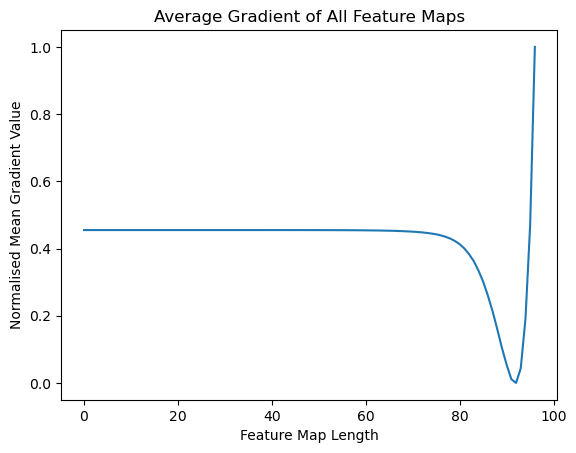

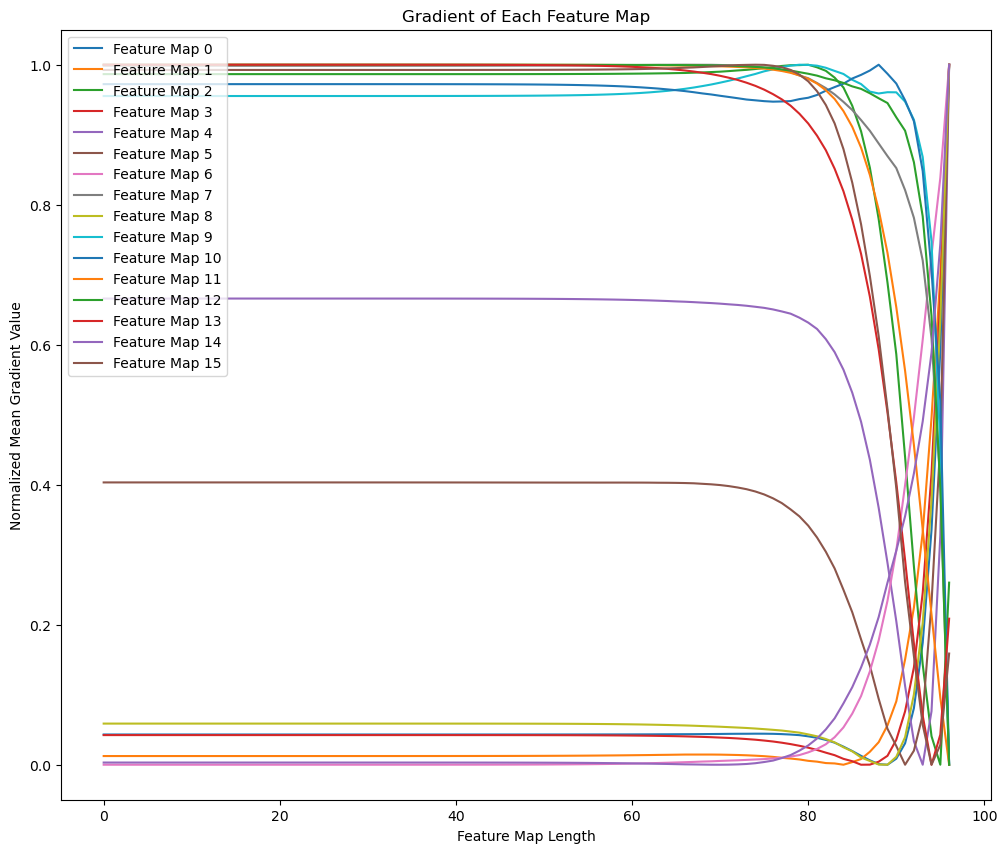

In [5]:
# Branch 1

norm_features = plot_feature_value.plot_ave_grad_all_f_maps(grads)

plot_feature_value.plot_indv_grad_f_maps(grads)

### Plotly/NetworkX Grad-CAM graph

In [7]:
# Get the entire patient's history in a DataFrame
edges_df = graph_plot.create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

l_map = gc.calc_local_map(model, grads, filt_num=1)

timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, l_map, max_timesteps)

read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_grad_df)

edge_pos_df = gc.create_edge_pos_df(edges_df, pos_df)

gc.plot_gradcam_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, 'all_filters_gradcam')